In [ ]:
!nvidia-smi

Mon Jan 17 14:49:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/Shareddrives/DKD/GAN/GANomaly'
! ls 


Mounted at /content/drive
/content/drive/Shareddrives/DKD/GAN/GANomaly
 Checkpoints		    GANomaly_Mnist.ipynb       Generator.h5
'Confusion matrix_cm.png'   Generator_cnt_loss_20.h5   name_model_roc_curve.png
 ganomaly-mnist.ipynb	    Generator_encoder.h5       pre_rec_curve.png


# **GANomaly**
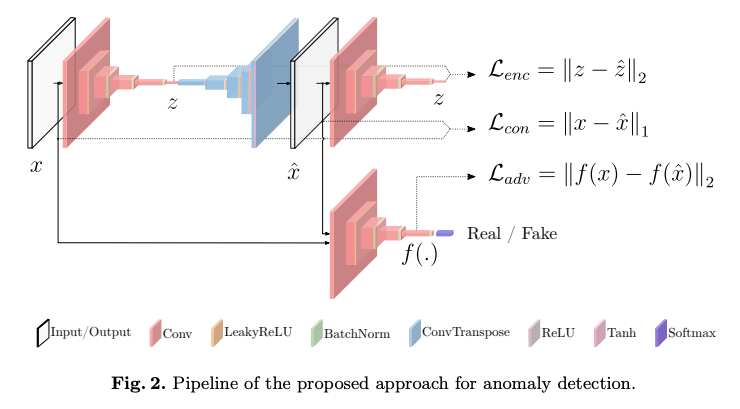

Anomaly detection is a classic problem in computer vision. Typically, it should be addressed as a supervised learning problem, but **this requires large, labeled datasets**. For many unusual real-world problems, cases samples are of insufficient sizes to be effectively modeled.


Autoencoder is usually used to reduce the data’s dimensions. Data would pass a neural network called encoder and be projected to lower space, and then pass to another network called decoder to the original space

Researchers used **encoder-decoder-encoder** sub-networks in the generator network to enable the model to map the input image to a lower dimension vector, which was then used to reconstruct the generated output image.

# **Import**

In [ ]:
import imp
import time
from keras import layers
import keras
import keras.backend as K
import tensorflow as tf
import numpy as np

np.random.seed(1234)

# **Model Setup**

In [ ]:
niter = 1000
bz = 16
width = 256
height = 256
# width = 64
# height = 64
channels = 1
show_summary=0
# In[] Generators Encoder
input_layer = layers.Input(name='input', shape=(height, width, channels))

# **Encoder of Generator part: Input(X) =>> G_Encode(X) ==> Latent space(Z)**

In [ ]:
# Encoder
x = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', kernel_regularizer = 'l2')(input_layer)
x = layers.LeakyReLU(name='leaky_1')(x)

x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='conv_2', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_1')(x)
x = layers.LeakyReLU(name='leaky_2')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_3', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_2')(x)
x = layers.LeakyReLU(name='leaky_3')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_3')(x)
x = layers.LeakyReLU(name='leaky_4')(x)

x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

g_e = keras.models.Model(inputs=input_layer, outputs=x)

if show_summary==1:
    g_e.summary()

# **Generator contains Encoder vs Decoder: Z ==> G_Decoder(Z) ===> FAKE Image(X_hat)**

In [ ]:
# In[] Generator
input_layer = layers.Input(name='input', shape=(height, width, channels))

x = g_e(input_layer)

y = layers.Dense(height * width * 2, name='dense')(x) # 2 = 128 / 8 / 8
y = layers.Reshape((height//8, width//8, 128), name='de_reshape')(y)

y = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', name='deconv_1', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_1')(y)

y = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', name='deconv_2', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_2')(y)

y = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', name='deconv_3', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_3')(y)

y = layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', name='decoder_deconv_output', kernel_regularizer = 'l2', activation='tanh')(y)

g = keras.models.Model(inputs=input_layer, outputs=y)
if show_summary==1:
    g.summary()

# **Encoder: FAKE Image(X_hat) ==> Encoder(X_hat)==>> Z_hat**

In [ ]:
# In[] Encoder
input_layer = layers.Input(name='input', shape=(height, width, channels))

z = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='encoder_conv_1', kernel_regularizer = 'l2')(input_layer)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='encoder_conv_2', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_1')(z)
z = layers.LeakyReLU()(z)


z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='encoder_conv_3', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_2')(z)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_41', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_3')(z)
z = layers.LeakyReLU()(z)

z = layers.GlobalAveragePooling2D(name='encoder_output')(z)

encoder = keras.models.Model(input_layer, z)
if show_summary==1:
    encoder.summary()

# **Feature extractor**

**Using CNN to extract the feature of image ==> Input of Discriminator**

In [ ]:
# In[] feature extractor
input_layer = layers.Input(name='input', shape=(height, width, channels))

f = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='f_conv_1', kernel_regularizer = 'l2')(input_layer)
f = layers.LeakyReLU(name='f_leaky_1')(f)

f = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='f_conv_2', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_1')(f)
f = layers.LeakyReLU(name='f_leaky_2')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_3', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_2')(f)
f = layers.LeakyReLU(name='f_leaky_3')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_4', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_3')(f)
f = layers.LeakyReLU(name='feature_output')(f)

feature_extractor = keras.models.Model(input_layer, f)
if show_summary==1:
    feature_extractor.summary()

# **Three loss functions: Adversarial Loss, Contextual Loss and Encoder Loss**

In [ ]:
# In[] gan trainer
class AdvLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdvLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori_feature = feature_extractor(x[0]) #feature extract from REAL DATA
        gan_feature = feature_extractor(x[1]) ##feature extract from FAKE DATA
        return K.mean(K.square(ori_feature - K.mean(gan_feature, axis=0)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class CntLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CntLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.abs(ori - gan))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class EncLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(g_e(ori) - encoder(gan)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)


# **Generator Model**

In [ ]:
# model for training
input_layer = layers.Input(name='input', shape=(height, width, channels))
gan = g(input_layer) # g(x)

adv_loss = AdvLoss(name='adv_loss')([input_layer, gan])
cnt_loss = CntLoss(name='cnt_loss')([input_layer, gan])
enc_loss = EncLoss(name='enc_loss')([input_layer, gan])

gan_trainer = keras.models.Model(input_layer, [adv_loss, cnt_loss, enc_loss])

# loss function
def loss(yt, yp):
    return yp

losses = {
    'adv_loss': loss,
    'cnt_loss': loss,
    'enc_loss': loss,
}

lossWeights = {'cnt_loss': 40.0, 'adv_loss': 1.0, 'enc_loss': 1.0}

# compile
gan_trainer.compile(optimizer = 'adam', loss=losses, loss_weights=lossWeights)
if show_summary==1:
    gan_trainer.summary()


# **Discriminator: Input of Discriminator is feature extractor , output is Binary: real/fake**

In [ ]:
# In[] discriminator
input_layer = layers.Input(name='input', shape=(height, width, channels))

f = feature_extractor(input_layer)

d = layers.GlobalAveragePooling2D(name='glb_avg')(f)
d = layers.Dense(1, activation='sigmoid', name='d_out')(d)
    
d = keras.models.Model(input_layer, d)
if show_summary==1:
    d.summary()

d.compile(optimizer='adam', loss='binary_crossentropy')


# **Mnist DATA**

11501568/11490434 [==============================] - 0s 0us/step


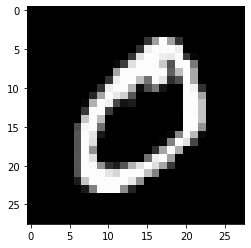

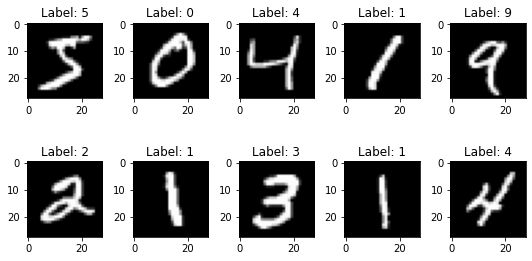

In [ ]:
import cv2
import numpy as np
# import custom_dataset
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
import matplotlib.pyplot as plt
%matplotlib inline

# pick a sample to plot
sample = 1
image = x_train[sample]# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

num = 10
images = x_train[:num]
labels = y_train[:num]

num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

10000
Shape x_ok before resize: (6742, 28, 28)
2167
1135
1032


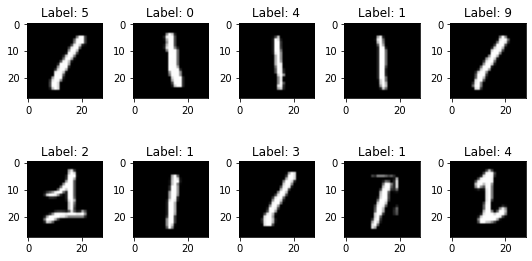

In [ ]:
from keras.datasets import mnist
import cv2
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(len(x_test))
x_ok = x_train[y_train == 1] # 6742 samples
x_test = x_test[(y_test == 1) | (y_test == 2)] # 1135 samples "1", 1028 samples "7"
y_test = y_test[(y_test == 1) | (y_test == 2)]
print("Shape x_ok before resize:",x_ok.shape)
print(len(x_test))
print(len(x_test[y_test==1]))
print(len(x_test[y_test==2]))

#Print X_training
num = 10
images = x_ok[:num]
labels = y_train[:num]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
def reshape_x(x):
    new_x = np.empty((len(x), width, height))
    for i, e in enumerate(x):
        new_x[i] = cv2.resize(e, (width, height))
    return np.expand_dims(new_x, axis=-1) / 127 - 1 #Normalize in the range [-1, 1]
  
x_ok = reshape_x(x_ok)
x_test = reshape_x(x_test)
print("Shape x_ok after resize:",x_ok.shape)
print("Shape x_test before resize:",x_test.shape)
x_ok.max()

Shape x_ok after resize: (6742, 256, 256, 1)
Shape x_test before resize: (2167, 256, 256, 1)


1.0078740157480315

**Label of Test Data =>> [0,1]**

In [ ]:
print(y_test[:20])
y_test[y_test == 1] = 0
y_test[y_test != 0] = 1
print(y_test[:10])

[2 1 1 1 1 1 2 1 2 1 1 2 1 2 1 2 1 2 2 1]
[1 0 0 0 0 0 1 0 1 0]


In [ ]:
# In[] Training
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]

train_data_generator = get_data_generator(x_ok, bz)

for i in range(niter):
    start_time = time.time()
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
        
    ### train disciminator ###
    d.trainable = True
        
    fake_x = g.predict(x)
        
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
        
    d_loss = d.train_on_batch(d_x, d_y)

    ### train generator ###
    
    d.trainable = False        
    g_loss = gan_trainer.train_on_batch(x, y,return_dict=True)
    if(type(g_loss)==dict):
        for k in g_loss.keys():
            g_loss[k]=round(g_loss[k], 4)

    speed =time.time() - start_time
    print(f'niter: {i+1}, G_loss: {g_loss}, D_loss: {d_loss:10.4f}, time: {speed:10.4f}s')

niter: 1, G_loss: {'loss': 43.224, 'adv_loss_loss': 0.0029, 'cnt_loss_loss': 0.9517, 'enc_loss_loss': 0.0044}, D_loss:     2.9592, time:    14.6697s
niter: 2, G_loss: {'loss': 42.6639, 'adv_loss_loss': 0.0055, 'cnt_loss_loss': 0.944, 'enc_loss_loss': 0.0059}, D_loss:     2.5712, time:     0.4885s
niter: 3, G_loss: {'loss': 42.0885, 'adv_loss_loss': 0.0085, 'cnt_loss_loss': 0.9353, 'enc_loss_loss': 0.0112}, D_loss:     2.5439, time:     0.4876s
niter: 4, G_loss: {'loss': 41.3274, 'adv_loss_loss': 0.0114, 'cnt_loss_loss': 0.9215, 'enc_loss_loss': 0.0032}, D_loss:     2.5138, time:     0.4708s
niter: 5, G_loss: {'loss': 39.9814, 'adv_loss_loss': 0.0136, 'cnt_loss_loss': 0.8919, 'enc_loss_loss': 0.0035}, D_loss:     2.4803, time:     0.4855s
niter: 6, G_loss: {'loss': 37.4517, 'adv_loss_loss': 0.0142, 'cnt_loss_loss': 0.8315, 'enc_loss_loss': 0.0055}, D_loss:     2.4441, time:     0.5039s
niter: 7, G_loss: {'loss': 33.0762, 'adv_loss_loss': 0.0123, 'cnt_loss_loss': 0.7242, 'enc_loss_loss':

# **Save the weight**

In [ ]:
# save model and architecture to single file
g_e.save("Generator_encoder.h5") #Generator Encoder
g.save("Generator.h5") #Generator
print("Saved GAN to disk")

Saved GAN to disk


# **Evaluation**

In [ ]:
# In[] Evaluation
encoded = g_e.predict(x_test) # Output is latent space Z
gan_x = g.predict(x_test)  #Generator make the Fake Image
encoded_gan = g_e.predict(gan_x) #Encode Fake Img =>> Z_hat
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1) #Score between Z and Z_hat L1_score
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

1032


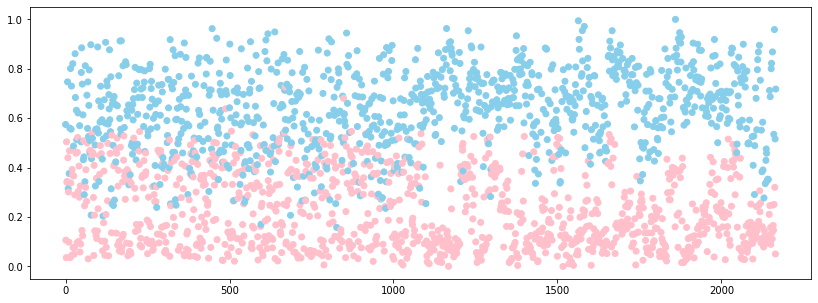

In [ ]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
print(len(x_test[y_test!=0]))
plt.scatter(range(len(x_test)), score, c=['skyblue' if x != 0 else 'pink' for x in y_test])

**Compare the Image generated from Generator and Anomaly Input Image**

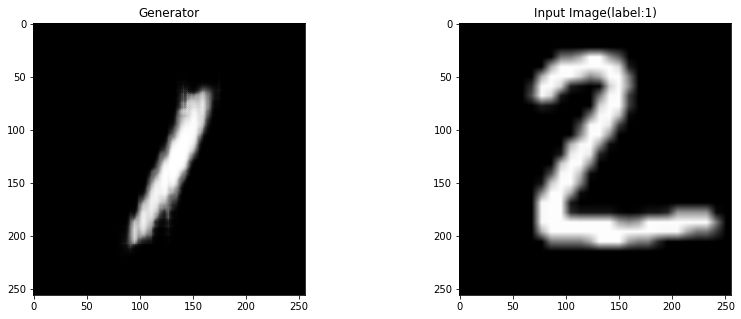

In [ ]:
# In[]
i = 0 # or 1
fig,ax = plt.subplots(1, 2)
image = np.reshape(gan_x[i:i+1], (height,width))
image = image * 127 + 127
ax[0].set_title("Generator")
ax[0].imshow(image.astype(np.uint8), cmap='gray')
image = np.reshape(x_test[i:i+1], (height,width))
image = image * 127 + 127
ax[1].set_title("Input Image(label:"+str(y_test[i])+")")
ax[1].imshow(image.astype(np.uint8), cmap='gray')

# **Receiver Operating Characteristic (ROC) and Confusion Matrix**

In [ ]:
# %%
from sklearn.metrics import f1_score, precision_score,roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from inspect import signature


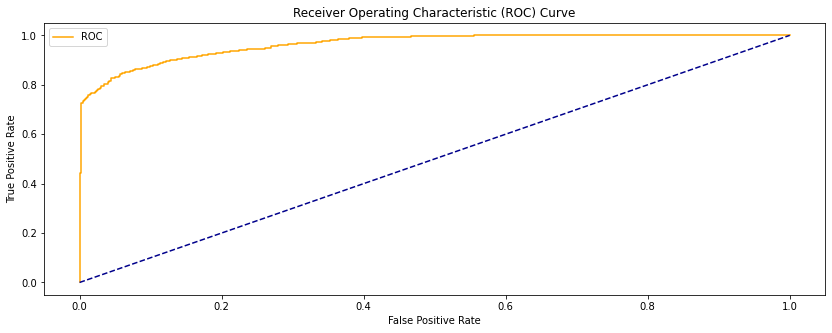

auc:  0.9636307755352935
threshold:  0.4703775
Accuracy:  0.8947854176280572
False Alarm Rate:  0.07234042553191489
Leakage Rate:  0.13039934800325997
precision_score:  0.9276595744680851
recall_score:  0.8449612403100775
F1-Score:  0.8843813387423934
Confusion matrix, without normalization
[[1067   68]
 [ 160  872]]


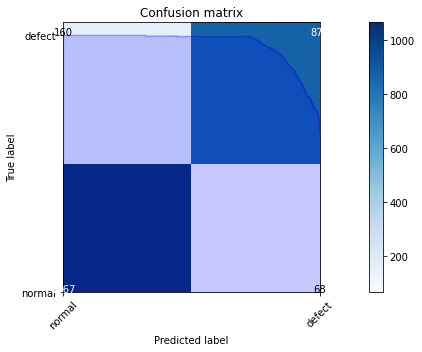

In [ ]:
from sklearn.metrics import f1_score, precision_score,roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from inspect import signature


# %%
import itertools

def plot_roc_curve(fpr, tpr, name_model):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.savefig(name_model+'_roc_curve.png')
    plt.show()
    # plt.close() 

def roc(labels, scores, name_model):
    """Compute ROC curve and ROC area for each class"""
    roc_auc = dict()
    # True/False Positive Rates.
    fpr, tpr, threshold = roc_curve(labels, scores)
    # print("threshold: ", threshold)
    roc_auc = auc(fpr, tpr)
    # get a threshod that perform very well.
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    # draw plot for ROC-Curve
    plot_roc_curve(fpr, tpr, name_model)
    
    return roc_auc, optimal_threshold

auc_out, threshold = roc(y_test, score, 'name_model')


predictions = (score > threshold).astype(int)
cm = tf.math.confusion_matrix(labels=y_test, predictions=predictions).numpy()
TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]




diagonal_sum = cm.trace()
sum_of_all_elements = cm.sum()
print("auc: ", auc_out)
print("threshold: ", threshold)
print("Accuracy: ", diagonal_sum / sum_of_all_elements )
print("False Alarm Rate: ", FP/(FP+TP))
print("Leakage Rate: ", FN/(FN+TN))
print("precision_score: ",precision_score(y_test, predictions))
print("recall_score: ", TP/(TP+FN))
#         F1 = 2 * (precision * recall) / (precision + recall)
print("F1-Score: ", f1_score(y_test, predictions))
# %%
def pre_rec_curve(labels, scores, show=False):
    average_precision = average_precision_score(labels, scores)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    if show:
        precision, recall, _ = precision_recall_curve(labels, scores)
        step_kwargs = ({
            'step': 'post'
        } if 'step' in signature(plt.fill_between).parameters else {})
        plt.figure()
        plt.step(recall, precision, color='b', alpha=0.2, where='post')
        plt.fill_between(recall,
                         precision,
                         alpha=0.2,
                         color='b',
                         **step_kwargs)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))
        plt.savefig("pre_rec_curve.png")
#         plt.close()
    return {'average_precision': average_precision}

pre_rec_curve=pre_rec_curve(y_test, score, show=True)
#%%
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title+'_cm.png')
    # plt.close()
class_names = ["normal", "defect"]
plot_confusion_matrix(cm, class_names, title='Confusion matrix')